This notebook uses LeCun et al's MNIST database of handwritten digits and my
vanilla MLP framework to train a three layer perceptron for digit
classification.

In [1]:
import os
import requests
import gzip
import struct
import random
import numpy as np
import matplotlib.pyplot as plt

Verify dataset exists or download it:

In [2]:
datasets = {
    'training images': 'train-images-idx3-ubyte.gz',
    'training labels': 'train-labels-idx1-ubyte.gz',
    'test images': 't10k-images-idx3-ubyte.gz',
    'test labels': 't10k-labels-idx1-ubyte.gz',
}
# remote_path = 'http://yann.lecun.com/exdb/mnist/'  # LeCun's site gives http error 403 (2024/05/26)
remote_path = 'https://github.com/jeremy-dolan/neural-net-from-scratch/raw/main/datasets/'
local_path = 'datasets'

if not os.path.exists(local_path):
    os.mkdir(local_path)

for dataset_name, filename in datasets.items():
    local_file = os.path.join(local_path, filename)
    if os.path.exists(local_file):
        print(f'{dataset_name} ({local_file}) exists')
    else:
        try:
            print(f'Downloading {dataset_name}...')
            response = requests.get(remote_path + filename)
            response.raise_for_status()
            try:
                with open(local_file, 'wb') as file:
                    file.write(response.content)
                    print(f"Saved {dataset_name} to {local_file}")
            except Exception as e:
                print(f"Unable to save {dataset_name} to {local_file}:\n{e}")
                raise
        except Exception as e:
            print(f'Unable to download {dataset_name} from {remote_path + filename}:\n{e}')
            raise

Saved training images to datasets/train-images-idx3-ubyte.gz
Saved training labels to datasets/train-labels-idx1-ubyte.gz
Saved test images to datasets/t10k-images-idx3-ubyte.gz
Saved test labels to datasets/t10k-labels-idx1-ubyte.gz


Read in the training data from "IDX" files, which are designed for homogenous
numerical data. Example file structure, for MNIST image database:

<small>

|offset |type              |value |description  |
|:-----:|:----------------:|:----:|:------------|
|0000   |magic number      |0x00  |—            |
|0001   |magic number      |0x00  |—            |
|0002   |8-bit MSB integer |0x08  |magic number; indicates the data is unsigned bytes |
|0003   |8-bit MSB integer |0x03  |number of dimensions for data (1 for vectors, 2 for matrices...) |
|0004   |32 bit integer    |60000 |number of images (dimension 1 size) |
|0008   |32 bit integer    |28    |number of rows (dimension 2 size) |
|0012   |32 bit integer    |28    |number of columns (dimension 3 size) |
|0016   |unsigned byte     |?     |pixel (0 for background, 255 for foreground) |
|0017   |unsigned byte     |?     |pixel |
|...    |...               |...   |...   |

</small>

The label file is similar, except offset 0003 is 0x01 (indicating one dimension to be specified), and
the data then begins at offset 0008.

In [3]:
LABEL_HEADER_LEN = 8
IMAGE_HEADER_LEN = 16

def verify_IDX_data(label_file:str, image_file:str) -> tuple[int, int, int]:
    '''sanity check an IDX formatted label/image file pair; return dimensions of image data'''

    # process labels database
    with gzip.open(label_file, 'rb') as labels:
        labels_header = labels.read(LABEL_HEADER_LEN)
        labels_magic_num = struct.unpack('>i', labels_header[0:4])[0]
        labels_count = struct.unpack('>i', labels_header[4:8])[0]
    with open(label_file, 'rb') as gz_labels:  # gzip stores the uncompressed size as the last 4 bytes
        gz_labels.seek(-4, 2)
        gz_footer = gz_labels.read(4)
        labels_data_size = struct.unpack('<I', gz_footer)[0]

    # process image database
    with gzip.open(image_file, 'rb') as images:
        images_header = images.read(IMAGE_HEADER_LEN)
        images_magic_num = struct.unpack('>i', images_header[0:4])[0]
        images_count = struct.unpack('>i', images_header[4:8])[0]
        rows_per_image = struct.unpack('>i', images_header[8:12])[0]
        cols_per_row = struct.unpack('>i', images_header[12:16])[0]
    with open(image_file, 'rb') as gz_images:
        gz_images.seek(-4, 2)
        gz_footer = gz_images.read(4)
        images_data_size = struct.unpack('<I', gz_footer)[0]

    assert labels_magic_num == 2049 # indicates data is unsigned bytes in 1-dimension
    assert images_magic_num == 2051 # indicates data is unsigned bytes in 3-dimensions
    assert labels_count == images_count
    assert labels_data_size == LABEL_HEADER_LEN + (labels_count)
    assert images_data_size == IMAGE_HEADER_LEN + (images_count * rows_per_image * cols_per_row)

    print(f'Verified {images_count} samples ({images_data_size:,} bytes uncompressed)')
    return images_count, rows_per_image, cols_per_row

def load_label_data(filename):
    with gzip.open(filename, 'rb') as f:
        f.seek(LABEL_HEADER_LEN)
        buffer = f.read()

        labels = np.frombuffer(buffer, dtype=np.uint8)
        print(f'Loaded {len(labels)} labels')
        return labels

def load_img_data(filename, data_shape):
    with gzip.open(filename, 'rb') as f:
        f.seek(IMAGE_HEADER_LEN)
        buffer = f.read()

        images = np.frombuffer(buffer, dtype=np.uint8)
        imgs, rows, cols = data_shape
        images = images.reshape(imgs, rows*cols)
        print(f'Loaded {len(images)} images of {rows*cols} pixels ({rows}x{cols})')
        return images


print('Training data:')
training_label_file = local_path + '/' + datasets['training labels']
training_image_file = local_path + '/' + datasets['training images']
training_data_shape = verify_IDX_data(training_label_file, training_image_file)
training_labels = load_label_data(training_label_file)
training_images = load_img_data(training_image_file, training_data_shape)

print('Test data:')
test_label_file = local_path + '/' + datasets['test labels']
test_image_file = local_path + '/' + datasets['test images']
test_data_shape = verify_IDX_data(test_label_file, test_image_file)
test_labels = load_label_data(test_label_file)
test_images = load_img_data(test_image_file, test_data_shape)

Training data:
Verified 60000 samples (47,040,016 bytes uncompressed)
Loaded 60000 labels
Loaded 60000 images of 784 pixels (28x28)
Test data:
Verified 10000 samples (7,840,016 bytes uncompressed)
Loaded 10000 labels
Loaded 10000 images of 784 pixels (28x28)


Preview a random sample of our training data:

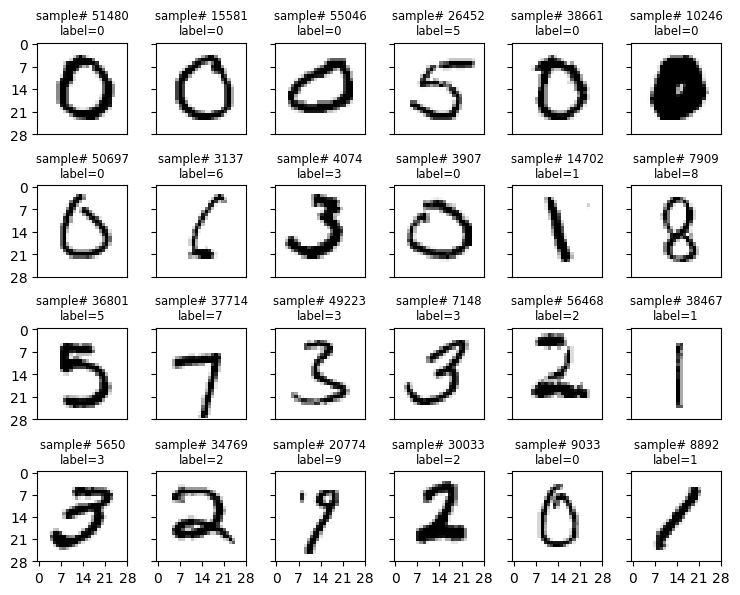

In [4]:
cols = 6
rows = 4
ticks = [x for x in range(0, training_data_shape[1]+1, training_data_shape[1]//4)]

fig, axs = plt.subplots(rows, cols, figsize=(cols*1.25, rows*1.5), sharey=True)
for i in range(rows):
    for j in range(cols):
        index = random.randint(0, training_data_shape[0])
        matrix = training_images[index].reshape(training_data_shape[1:3])
        axs[i, j].matshow(matrix, cmap='gray_r')
        axs[i, j].set_title(f'sample# {index+1}\nlabel={training_labels[index]}', fontsize='small')
        axs[i, j].set_yticks(ticks)
        if i == rows-1: # last row: show x axis
            axs[i, j].set_xticks(ticks)
            axs[i, j].xaxis.set_ticks_position('bottom')
        else:
            axs[i, j].set_xticks([])     # suppress x-axis ticks

plt.tight_layout()
plt.show()

In [5]:
# convert to framework's format for training data
#   for the input images, scale pixel values to normalize to the 0-1 range
#   for the output labels, convert integers [0, 9] to a one-hot encoded vector

training_data = [
    {
        'x': image/255,
        'y': [1 if i == label else 0 for i in range(10)]    # could use a sparse int encoding if I change loss fxs
    }
      for image,label in zip(training_images, training_labels)
]

test_data = [
    {
        'x': image/255,
        'y': [1 if i == label else 0 for i in range(10)]
    }
      for image,label in zip(test_images, test_labels)
]

assert len(training_data) == training_data_shape[0]
assert len(training_data[0]['x']) == training_data_shape[1] * training_data_shape[2]
assert max(training_data[0]['x']) <= 1
assert len(training_data[0]['y']) == 10

Our data is ready. Now define the neural network:

In [6]:
from mlp_framework_vanilla import *

inputs = 784         # pixel values
layer_1_nodes = 8   # fc layer 1
layer_2_nodes = 8   # fc layer 2
output_nodes = 10    # classification categories

mnist_net = Net(inputs,
                shape=[layer_1_nodes, layer_2_nodes, output_nodes],
                activation_fxs=[ReLU, ReLU, softmax],
                loss_fx=categorical_cross_entropy)

# alternatively, one-vs-rest (OvR) classification:
# mnist_net = Net(inputs, [layer_1_nodes, layer_2_nodes, output_nodes], [ReLU]*2+[sigmoid], loss_fx=binary_cross_entropy)

And train it:

In [7]:
training_result = mnist_net.train(training_data, epochs=10, learning_rate=0.35,
                          batch_size=32, batch_progress_every=0,
                          test_every=1, test_data=test_data)

epoch  1 complete, 1875 batches, training_loss=0.86681, test_loss=0.64046, accuracy: 8221/10000
epoch  2 complete, 1875 batches, training_loss=0.51648, test_loss=0.47697, accuracy: 8571/10000
epoch  3 complete, 1875 batches, training_loss=0.43422, test_loss=0.41637, accuracy: 8851/10000
epoch  4 complete, 1875 batches, training_loss=0.40816, test_loss=0.39287, accuracy: 8869/10000
epoch  5 complete, 1875 batches, training_loss=0.38718, test_loss=0.38542, accuracy: 8971/10000
epoch  6 complete, 1875 batches, training_loss=0.37112, test_loss=0.38568, accuracy: 8972/10000
epoch  7 complete, 1875 batches, training_loss=0.35645, test_loss=0.40590, accuracy: 8888/10000
epoch  8 complete, 1875 batches, training_loss=0.35099, test_loss=0.36380, accuracy: 9040/10000
epoch  9 complete, 1875 batches, training_loss=0.34290, test_loss=0.38469, accuracy: 8915/10000
epoch 10 complete, 1875 batches, training_loss=0.33897, test_loss=0.40285, accuracy: 8840/10000


Train a few more epochs with a lower learning rate:

In [8]:
additional_training_result = mnist_net.train(training_data, epochs=5, learning_rate=0.1,
                                             batch_size=32, batch_progress_every=0,
                                             test_every=1, test_data=test_data)
# append results:
for key in training_result:
    training_result[key] += additional_training_result[key]

epoch 1 complete, 1875 batches, training_loss=0.26424, test_loss=0.28340, accuracy: 9204/10000
epoch 2 complete, 1875 batches, training_loss=0.25602, test_loss=0.28292, accuracy: 9189/10000
epoch 3 complete, 1875 batches, training_loss=0.25415, test_loss=0.29225, accuracy: 9167/10000
epoch 4 complete, 1875 batches, training_loss=0.25151, test_loss=0.28501, accuracy: 9192/10000
epoch 5 complete, 1875 batches, training_loss=0.25002, test_loss=0.28304, accuracy: 9175/10000


Visualize the training and test loss across epochs:

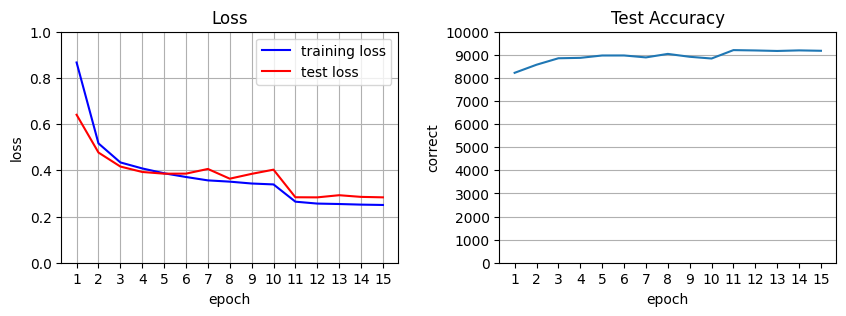

In [9]:
def plot_results(results):
    epochs = range(1, len(results["training_loss"])+1)
    sample_count = results["test_accuracy"][0][1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1:plt.Axes
    ax2:plt.Axes

    fig.subplots_adjust(wspace=0.3)

    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(epochs, results["training_loss"], color="blue", label="training loss")
    ax1.plot(epochs, results["test_loss"], color="red", label="test loss")
    ax1.set_ylim(bottom=0, top=1)
    ax1.set_xticks(epochs)
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('correct')
    ax2.plot(epochs, [row[0] for row in results["test_accuracy"]])
    ax2.set_ylim(bottom=0, top=sample_count)
    ax2.set_xticks(epochs)
    ax2.set_yticks(range(0, sample_count+1, sample_count//10))
    ax2.grid(True, axis='y')

    plt.show()

plot_results(training_result)

(The test loss is much smaller than training loss for epoch 1 because the test
loss is calculated *after* the network has had a full epoch's worth of training
(and our training set is rather large), while the training loss starts to
accumulate when the weights are completely random.)

Although the model learns to classify around 90% of the images correctly, it
stalls at around that level of accuracy.

Let's visualize some of its predictions on the test images:

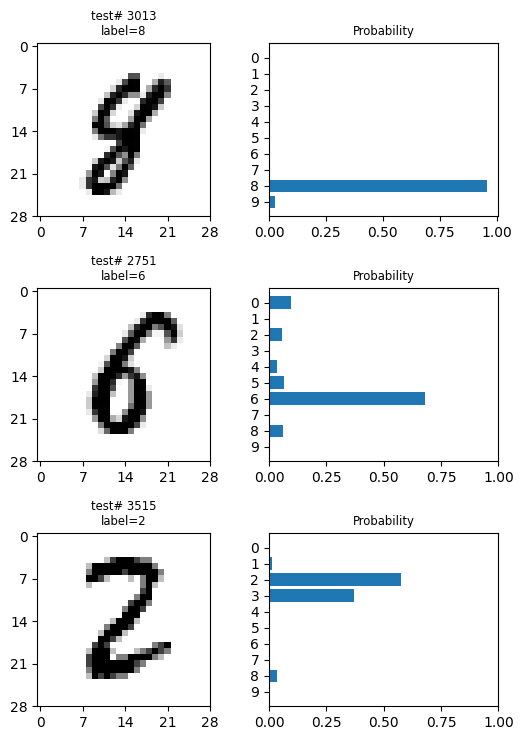

In [10]:
ticks = [x for x in range(0, test_data_shape[1]+1, test_data_shape[1]//4)]
rows = 3

fig, axs = plt.subplots(rows, 2, figsize=(5.5, rows*2.5))

for i in range(rows):
    index = random.randint(0, test_data_shape[0])
    sample = test_data[index]

    if rows == 1: # special case, ndarray is 1D
        ax_image:plt.Axes = axs[0]
        ax_graph:plt.Axes = axs[1]
    else:
        ax_image:plt.Axes = axs[i,0]
        ax_graph:plt.Axes = axs[i,1]

    # see if it draws the same using test_images original, or test_data:
    matrix = test_images[index].reshape(test_data_shape[1:3])
    ax_image.matshow(matrix, cmap='gray_r')
    ax_image.set_title(f'test# {index+1}\nlabel={sample["y"].index(1)}', fontsize='small')
    ax_image.set_yticks(ticks)
    ax_image.set_xticks(ticks)
    ax_image.xaxis.set_ticks_position('bottom')

    prediction = mnist_net.forward(sample['x'])[-1]
    classes = list(range(10))
    ax_graph.set_title(f'Probability', fontsize='small')
    ax_graph.barh(classes, prediction)
    ax_graph.set_yticks(classes, labels=classes)
    ax_graph.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax_graph.invert_yaxis()  # provided labels are top-to-bottom
    


def one_hot_to_category(one_hot_label, categories):
    if one_hot_label.count(1) != 1:
        raise ValueError("Invalid one-hot encoded vector")
    index = one_hot_label.index(1)
    return categories[index]


plt.tight_layout()
plt.show()

Along the left are three random test images, and on the right the model's
prediction: a probability distribution over all the digit classes.

So the model was very confident about the 8, less so about the 6, and barely
predicted 2 over 3 for the 2.

### Confusion matrix

We can see the model's overall patterns of accuracy by plotting a confusion
matrix. Each row represents the actual category of a sample, and the value in
each column represents the number of samples that we classified as that label.
(Thus, the diagonal represents correct predictions.)

In [11]:
# initialize:
conf_mat = [[0 for _ in range(10)] for _ in range(10)]

for sample in test_data:
    x = sample['x']
    y = sample['y']
    ŷ = mnist_net.forward(x)[-1]

    true_class = y.index(1)
    predicted_class = ŷ.index(max(ŷ))

    conf_mat[true_class][predicted_class] += 1

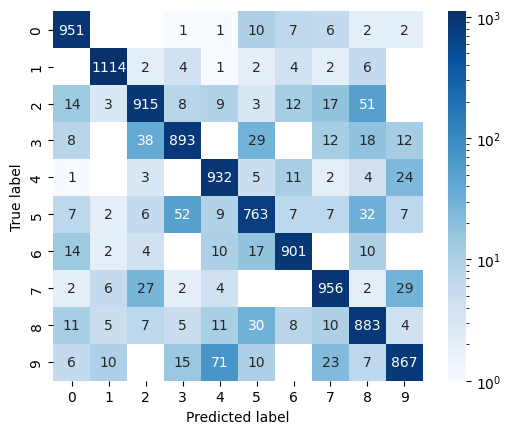

In [12]:
import seaborn as sns
from matplotlib.colors import LogNorm
ax = sns.heatmap(conf_mat, cmap='Blues', square=True, norm=LogNorm(), annot=True, fmt='d')
ax.set(ylabel="True label", xlabel="Predicted label")
plt.show()

3 was often predicted as 2, 5/3 were often confused, as were 7/2, 8/5, and 4/9, to name a few. These digits definitely have similar parts of their shapes. Let's try doubling the width of our two hidden layers (from 8 nodes each to 16 nodes) and see how accuracy is affected:

In [13]:
inputs = 784         # pixel values
layer_1_nodes = 16   # fc layer 1
layer_2_nodes = 16   # fc layer 2
output_nodes = 10    # classification categories

mnist_net_2 = Net(inputs,
                shape=[layer_1_nodes, layer_2_nodes, output_nodes],
                activation_fxs=[ReLU]*2+[softmax],
                loss_fx=categorical_cross_entropy)

training_result_2 = mnist_net_2.train(training_data, epochs=15, learning_rate=0.2,
                          batch_size=64, batch_progress_every=0,
                          test_every=1, test_data=test_data)

epoch  1 complete, 938 batches, training_loss=0.61955, test_loss=0.36087, accuracy: 8896/10000
epoch  2 complete, 938 batches, training_loss=0.32454, test_loss=0.30611, accuracy: 9074/10000
epoch  3 complete, 938 batches, training_loss=0.26883, test_loss=0.23490, accuracy: 9272/10000
epoch  4 complete, 938 batches, training_loss=0.23672, test_loss=0.24497, accuracy: 9238/10000
epoch  5 complete, 938 batches, training_loss=0.21599, test_loss=0.20691, accuracy: 9371/10000
epoch  6 complete, 938 batches, training_loss=0.20192, test_loss=0.28786, accuracy: 9127/10000
epoch  7 complete, 938 batches, training_loss=0.19042, test_loss=0.21499, accuracy: 9382/10000
epoch  8 complete, 938 batches, training_loss=0.18150, test_loss=0.19338, accuracy: 9430/10000
epoch  9 complete, 938 batches, training_loss=0.17355, test_loss=0.19872, accuracy: 9418/10000
epoch 10 complete, 938 batches, training_loss=0.16908, test_loss=0.18219, accuracy: 9488/10000
epoch 11 complete, 938 batches, training_loss=0.16

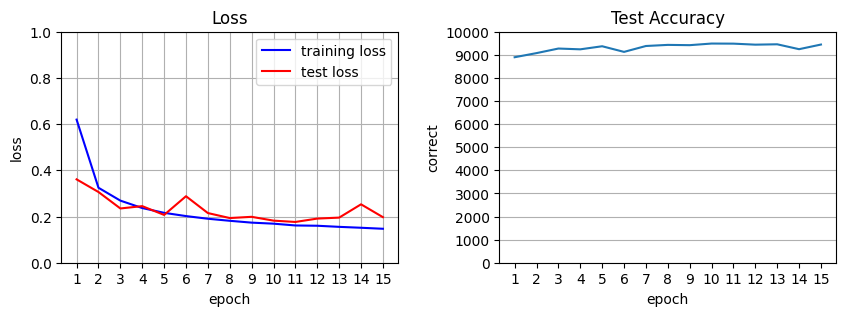

In [14]:
plot_results(training_result_2)

Let's try a couple more epochs with lower learning rates to let the weights nestle a little deeper into the loss minima:


In [15]:
# epochs=2, learning_rate=0.1, batch_size=64
additional_training_result_2 = mnist_net_2.train(training_data, epochs=2, learning_rate=0.1,
                                                 batch_size=64, batch_progress_every=0,
                                                 test_every=1, test_data=test_data)
for key in training_result_2:
    training_result_2[key] += additional_training_result_2[key]

epoch 1 complete, 938 batches, training_loss=0.12674, test_loss=0.16319, accuracy: 9529/10000
epoch 2 complete, 938 batches, training_loss=0.12370, test_loss=0.16560, accuracy: 9528/10000


In [16]:
# epochs=3, learning_rate=0.05, batch_size=128
additional_training_result_2 = mnist_net_2.train(training_data, epochs=3, learning_rate=0.05,
                                                 batch_size=128, batch_progress_every=0,
                                                 test_every=1, test_data=test_data)
for key in training_result_2:
    training_result_2[key] += additional_training_result_2[key]

epoch 1 complete, 469 batches, training_loss=0.11225, test_loss=0.15325, accuracy: 9552/10000
epoch 2 complete, 469 batches, training_loss=0.11056, test_loss=0.15475, accuracy: 9558/10000
epoch 3 complete, 469 batches, training_loss=0.11008, test_loss=0.15453, accuracy: 9552/10000


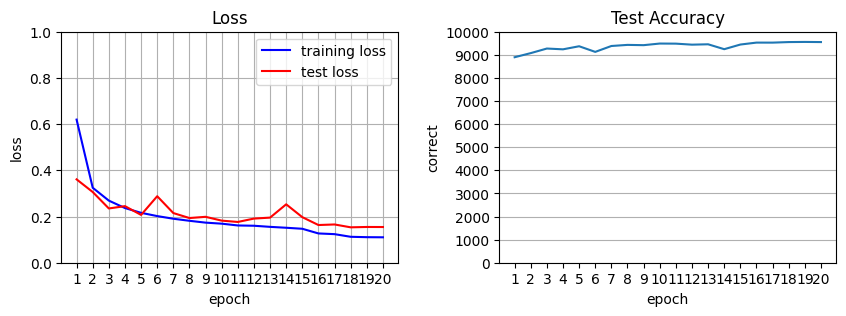

In [17]:
plot_results(training_result_2)

95.5% accuracy at a 10-category classification task seems not too bad for a
simple multi-layer perceptron with only two hidden layers of 16 nodes each.

Let's peek at some of the test images the model is still getting wrong. (How
hard to categorize are they? Are they even correctly labeled?)

In [ ]:
# pull random samples from test set that were classified incorrectly.
# does it make sense for Net.test() to return a list of sample indices that were incorrect?
# probably, but we have to refactor the data shuffling to use indices rather than the sample list itself...

In [ ]:
# Interactive digit drawing with live classification
from ipycanvas import Canvas, hold_canvas

logical_px_size = training_data_shape[1]

canvas = Canvas(width=20*logical_px_size, height=20*logical_px_size)
canvas.fill_style = "#eeeeee"
canvas.fill_rect(0, 0, 20*logical_px_size, 20*logical_px_size)

objects_to_draw = []

class LogicalPixel:
    def __init__(self, x, y):
        self.x = x*logical_px_size
        self.y = y*logical_px_size
        self.width = logical_px_size
        self.height = logical_px_size
        self.selected = False
        objects_to_draw.append(self)

    def draw(self):
        canvas.fill_style = "#000000"
        if self.selected:
            canvas.fill_style = "#000000"
        else:
            canvas.fill_style = "#eeeeee"
        canvas.fill_rect(self.x, self.y, self.width, self.height)

def handle_mouse_down():
    pass
def handle_mouse_up():
    pass
def handle_mouse_move():
    pass
canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_up(handle_mouse_up)
canvas.on_mouse_move(handle_mouse_move)
# touch screen events: on_touch_start, on_touch_end, on_touch_move

canvas

In [37]:
import pickle
pkl_file = 'dev/mnist_net.pkl'

In [38]:
# # Save weights (commented out to prevent accidental overwrite)
# variables_to_save = {
#     'mnist_net': mnist_net,
#     'training_result': training_result,
#     'mnist_net_2': mnist_net_2,
#     'training_result_2': training_result_2,
# }
# with open(pkl_file, 'wb') as f:
#     pickle.dump(variables_to_save, f)

In [13]:
# Reload weights

import numpy as np
import matplotlib.pyplot as plt
from mlp_framework_vanilla import *

with open(pkl_file, 'rb') as f:
    loaded_variables = pickle.load(f)

mnist_net = loaded_variables['mnist_net']
training_result = loaded_variables['training_result']
mnist_net_2 = loaded_variables['mnist_net_2']
training_result_2 = loaded_variables['training_result_2']